In [127]:
import math
import datetime
from matplotlib import pyplot as plt
from FinMind.Data import Load
import numpy as np
import json
import pandas as pd
TaiwanStockInfo = Load.FinData(dataset = 'TaiwanStockInfo')
  

stock_id=2548
some_days_ago=700

data = Load.FinData(dataset = 'TaiwanStockPrice',select = [str(stock_id)],date = str(datetime.date.today()-datetime.timedelta(days = some_days_ago)))

In [135]:
data[58:]

,date,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,stock_id,update_time,create_time,rmax,rmin,local_max_or_not,local_min_or_not,critical
58,2017-10-16,1163791,80823769,69.1,69.9,69.0,69.9,0.8,909,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,65.2,True,False,True
59,2017-10-17,686674,47736704,69.9,70.0,69.0,69.6,-0.3,600,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,66.2,False,False,False
60,2017-10-18,634898,43680393,69.8,69.8,68.2,68.6,-1.0,582,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,66.2,False,False,False
61,2017-10-19,1247832,84573921,68.7,68.9,67.2,68.0,-0.6,960,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,66.3,False,False,False
62,2017-10-20,1639535,110794180,67.5,68.2,67.0,68.2,0.2,745,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,66.6,False,False,False
63,2017-10-23,499019,33839392,68.3,68.4,67.6,67.8,-0.4,378,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,66.6,False,False,False
64,2017-10-24,265440,17963076,67.8,67.9,67.5,67.7,-0.1,204,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,67.3,False,False,False
65,2017-10-25,351438,23919664,67.8,68.5,67.6,68.2,0.5,271,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,67.3,False,False,False
66,2017-10-26,454249,30801205,68.2,68.2,67.6,67.8,-0.4,244,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,67.3,False,False,False
67,2017-10-27,420114,28460127,67.8,68.0,67.5,67.8,0.0,296,2548,2019-05-23 02:11:32,2019-06-15 11:14:25,69.9,67.3,False,False,False


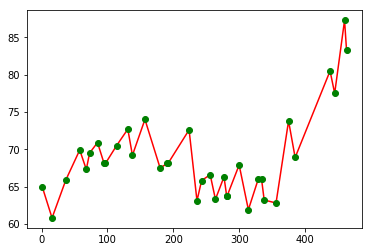

In [129]:
#####
def make_line(data,rolling_num=20):
#     data['close'].plot(figsize=(16,9))
    #center 和 min_periods很重要
    data['rmax']=data['close'].rolling(rolling_num,min_periods=1,center=True).max()
    data['rmin']=data['close'].rolling(rolling_num,center=True,min_periods=1).min()   
    data['local_max_or_not']=data['rmax']==data['close']
    data['local_min_or_not']=data['rmin']==data['close']
    #找到重要的直
    data['critical']=np.logical_or(data['local_max_or_not'],data['local_min_or_not'])
#     畫圖
    plt.plot(data['close'][data['critical']],'r-')
    plt.plot(data['close'][data['critical']],'go')
    return data
result=make_line(data)
plt.show()

In [136]:
#功能：判斷上升段 下降段
#有三種可能 上升 平 下降
critical_point_list=data['critical']
critical_price       =data[['close']][critical_point_list]
critical_price['index']= critical_price.index
critical_price['gap']=critical_price['close']-critical_price['close'].shift(1)
ans=map(lambda x:'up' if x>0  else 'down' if x<0 else 'flat' if x==0 else 'non',critical_price['gap'])
critical_price['type']=list(ans)
critical_price=critical_price[critical_price['type']!='flat']
critical_price['next_type']=critical_price['type'].shift(-1)
critical_price=critical_price[critical_price['next_type']!=critical_price['type']]
del critical_price['next_type']

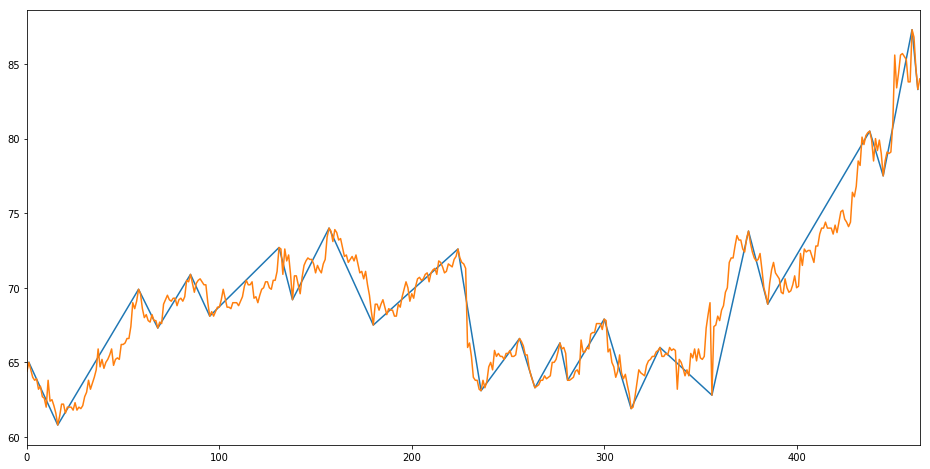

In [137]:
#測試畫完的圖
data.iloc[critical_price.index]['close'].plot()
data['close'].plot(figsize=(16,8))
plt.show()

In [138]:
essential_data=data.iloc[critical_price.index][['date','close']]
essential_data['next_close']=essential_data['close'].shift(-1)
essential_data['type']=critical_price['type'].shift(-1)
essential_data['mid_point']=(essential_data['close']+essential_data['close'].shift(-1))/2
essential_data['last_mid_point']=essential_data['mid_point'].shift(1)
essential_data['type1_buy']=np.logical_and(list(essential_data['type']=='down'),list(essential_data['next_close']>= essential_data['last_mid_point']))
essential_data['type1_sell']=np.logical_and(list(essential_data['type']=='up'),list(essential_data['next_close']<essential_data['last_mid_point']))

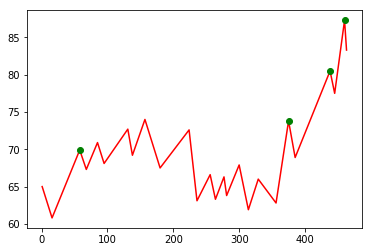

In [139]:
plt.plot(essential_data['close'],'r-')
plt.plot(essential_data['close'][essential_data['type1_buy']],'go')
plt.show()

In [140]:
essential_data[essential_data['type1_buy']]
#資料表的格式需要 第二波的起點(當作判斷是否能TYPE1的購買) 第一波的中間點(判斷是否波型破壞)=>essential data裡面都有這些東西
#STEP1 提取資料 接下來從INDEX +1開始進行判斷

,date,close,next_close,type,mid_point,last_mid_point,type1_buy,type1_sell
58,2017-10-16,69.9,67.3,down,68.60,65.35,True,False
375,2019-01-23,73.8,68.9,down,71.35,68.30,True,False
438,2019-05-08,80.5,77.5,down,79.00,74.70,True,False
460,2019-06-10,87.3,83.3,down,85.30,82.40,True,False


In [147]:
essential_data['index']=essential_data.index
essential_data['next_index']=essential_data['index'].shift(-1)
essential_data

,date,close,next_close,type,mid_point,last_mid_point,type1_buy,type1_sell,index,next_index
1,2017-07-25,65.0,60.8,down,62.90,NaN,False,False,1,16.0
16,2017-08-15,60.8,69.9,up,65.35,62.90,False,False,16,58.0
58,2017-10-16,69.9,67.3,down,68.60,65.35,True,False,58,68.0
68,2017-10-30,67.3,70.9,up,69.10,68.60,False,False,68,85.0
85,2017-11-22,70.9,68.1,down,69.50,69.10,False,False,85,95.0
95,2017-12-06,68.1,72.7,up,70.40,69.50,False,False,95,131.0
131,2018-01-26,72.7,69.2,down,70.95,70.40,False,False,131,138.0
138,2018-02-06,69.2,74.0,up,71.60,70.95,False,False,138,157.0
157,2018-03-14,74.0,67.5,down,70.75,71.60,False,False,157,180.0
180,2018-04-18,67.5,72.6,up,70.05,70.75,False,False,180,224.0


In [101]:
lose_list              = []
earn_list              = []
for i in essential_data[essential_data['type1_buy']].iterrows():
    start_index            = i[0]                       #起始日期的INDEX
    list_obj               = i[1]                       #上面那個表(essential_data)的一列
    now_index              = start_index                #開始迴圈時當前日期的index   
    start_point            = list_obj['close']          #第一波的最高點 當超過最高點時就啟動了
    wave_control_condition = list_obj['last_mid_point'] #第一波的中間點 當低於這個點波型破壞 
    first_wave_gap         = abs(start_point-wave_control_condition)*2
    purchase               = False
    purchase_price         = 0
    stop_loss_factor       = 20                         #跌超過20%就停損
    nfactor                = 3                         #漲超過第一波的n倍就停利
    
    #logic compute
    while(now_index<=(len(data)-1)):
        now_price    =data['close'][now_index]
        now_index+=1
        if(purchase):
                    if -now_price+purchase_price>purchase_price*(1-stop_loss_factor/100):
#                         print('賠太多 殺出')
                        lose_list.append([-now_price+purchase_price,now_price,start_index,now_index,first_wave_gap])
                        break

                    if now_price<wave_control_condition:
                        print('波破壞 退出 認賠')
                        losemoney=data['close'][start_index]-data['close'][now_index]
#                         print(losemoney)
                        lose_list.append([losemoney,now_price,start_index,now_index,first_wave_gap])
                        purchase         =False
                        break
                    elif (now_price-purchase_price)>first_wave_gap*nfactor:
#                         print('收手有賺錢 賺了',now_price-purchase_price,'現在價格',now_price)
                        purchase         =False
                        earn_list.append([now_price-purchase_price,now_price,start_index,now_index,first_wave_gap])
                        break
                
        elif(not purchase):
                    if now_price<wave_control_condition:
                        print('波破壞 退出')
                        break
                    elif now_price> start_point:
                        purchase       = True
                        purchase_price = now_price
                        #print('type1發動---購買價格',purchase_price,'第一波漲幅',first_wave_gap)

earn_list=pd.DataFrame(earn_list,columns=['賺了','當前價格','買入日','賣出日','波一漲幅'])
lose_list=pd.DataFrame(lose_list,columns=['賠了','當前價格','買入日','賣出日','波一漲幅'])
combine_list = pd.DataFrame()

波破壞 退出 認賠
波破壞 退出 認賠


In [102]:
earn_list

,賺了,當前價格,買入日,賣出日,波一漲幅


In [103]:
lose_list

,賠了,當前價格,買入日,賣出日,波一漲幅
0,11.0,227.5,253,303,36.0
1,21.0,250.0,281,300,25.5


In [61]:
#輸出結果
earn_money=earn_list['賺了'].sum()
invest_money = earn_list['當前價格'].sum()
invest_money

0

In [104]:
def test1(stock_id,some_days_ago,rolling_num=20):
    data = Load.FinData(dataset = 'TaiwanStockPrice',select = [str(stock_id)],date = str(datetime.date.today()-datetime.timedelta(days = some_days_ago))) 
    data['rmax']=data['close'].rolling(rolling_num,min_periods=1,center=True).max()
    data['rmin']=data['close'].rolling(rolling_num,center=True,min_periods=1).min()   
    data['local_max_or_not']=data['rmax']==data['close']
    data['local_min_or_not']=data['rmin']==data['close']
    data['critical']=np.logical_or(data['local_max_or_not'],data['local_min_or_not'])
   
    essential_data=data.iloc[critical_price.index][['date','close']]
    essential_data['next_close']=essential_data['close'].shift(-1)
    essential_data['type']=critical_price['type'].shift(-1)
    essential_data['mid_point']=(essential_data['close']+essential_data['close'].shift(-1))/2
    essential_data['last_mid_point']=essential_data['mid_point'].shift(1)
    essential_data['type1_buy']=np.logical_and(list(essential_data['type']=='down'),list(essential_data['next_close']>= essential_data['last_mid_point']))
    essential_data['type1_sell']=np.logical_and(list(essential_data['type']=='up'),list(essential_data['next_close']<essential_data['last_mid_point']))
    print(essential_data[essential_data['type1_buy']])
    lose_list              = []
    earn_list              = []
    for i in essential_data[essential_data['type1_buy']].iterrows():
        start_index            = i[0]                       #起始日期的INDEX
        list_obj               = i[1]                       #上面那個表(essential_data)的一列
        now_index              = start_index                #開始迴圈時當前日期的index   
        start_point            = list_obj['close']          #第一波的最高點 當超過最高點時就啟動了
        wave_control_condition = list_obj['last_mid_point'] #第一波的中間點 當低於這個點波型破壞 
        first_wave_gap         = abs(start_point-wave_control_condition)*2
        purchase               = False
        purchase_price         = 0
        stop_loss_factor       = 20                         #跌超過20%就停損
        nfactor                = 3                         #漲超過第一波的n倍就停利

        #logic compute
        while(now_index<=(len(data)-1)):
            now_price    =data['close'][now_index]
            now_index+=1
            if(purchase):
                        if -now_price+purchase_price>purchase_price*(1-stop_loss_factor/100):
    #                         print('賠太多 殺出')
                            lose_list.append([-now_price+purchase_price,now_price,start_index,now_index,first_wave_gap])
                            break

                        if now_price<wave_control_condition:
                            print('波破壞 退出 認賠')
                            losemoney=data['close'][start_index]-data['close'][now_index]
    #                         print(losemoney)
                            lose_list.append([losemoney,now_price,start_index,now_index,first_wave_gap])
                            purchase         =False
                            break
                        elif (now_price-purchase_price)>first_wave_gap*nfactor:
    #                         print('收手有賺錢 賺了',now_price-purchase_price,'現在價格',now_price)
                            purchase         =False
                            earn_list.append([now_price-purchase_price,now_price,start_index,now_index,first_wave_gap])
                            break

            elif(not purchase):
                        if now_price<wave_control_condition:
                            break
                        elif now_price> start_point:
                            purchase       = True
                            purchase_price = now_price
                            #print('type1發動---購買價格',purchase_price,'第一波漲幅',first_wave_gap)

    earn_list=pd.DataFrame(earn_list,columns=['賺了','當前價格','買入日','賣出日','波一漲幅'])
    earn_list['號碼']=stock_id
    lose_list=pd.DataFrame(lose_list,columns=['賠了','當前價格','買入日','賣出日','波一漲幅'])
    lose_list['號碼']=stock_id
    return [earn_list,lose_list]
    

In [84]:
rs=test1(1101,700)

In [117]:
rs2=test1(8088,700)

           date  close  next_close  type  mid_point  last_mid_point  \
340  2018-12-04  13.50        12.3  down     12.900          12.075   
367  2019-01-11  13.00        13.1  down     13.050          12.650   
407  2019-03-21  12.85        13.4  down     13.125          12.975   
427  2019-04-22  18.60        16.6  down     17.600          16.000   

     type1_buy  type1_sell  
340       True       False  
367       True       False  
407       True       False  
427       True       False  


In [120]:
rs2[0]

,賺了,當前價格,買入日,賣出日,波一漲幅,號碼
0,2.9,16.0,367,418,0.7,8088


In [121]:
pd.concat([rs[0],rs2[0]])

,賺了,當前價格,買入日,賣出日,波一漲幅,號碼
0,7.70,45.9,158,200,2.1,1101
1,7.65,44.0,349,462,2.5,1101
0,2.90,16.0,367,418,0.7,8088
